In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

__author__ = "Sid Vanam"
__email__ = "vanamsid@gmail.com"

In [2]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv') #DON'T TOUCH

train_sal = pd.read_csv("train_salaries.csv") #only jobID and Salary

In [3]:
def feature_order(feature, ascending = True):
    grouped_df = train_full.groupby(feature)['salary'].mean().sort_values().reset_index()
    if ascending == False:
        sorted_df = grouped_df.sort_values(by = 'salary', ascending = False).reset_index()
        return sorted_df[feature].tolist()
    else:
        sorted_df = grouped_df.sort_values(by = 'salary', ascending = True).reset_index()
        return sorted_df[feature].tolist()

def plot_viz(feature):
    ''' Plots Feature against Salary (Boxenplot)'''
    plt.figure(figsize = (20,7))
    plt.title(feature + ' vs. Salary')
    plt.ylabel('Salary')
    plt.xlabel(feature)
    if feature == 'companyId':
        plt.xticks(rotation = 90)
    
    return sns.boxenplot(x = feature, y = 'salary', data = train_full, order = feature_order(feature))

def find_outliers(df, feature, lower = False, view = 10):
    describe_df = df[feature].describe().reset_index()
    if lower == True:
        q1 = describe_df.iloc[4][feature]
        return df.loc[df[feature] < q1].sort_values(by= feature, ascending = True).head(view)
    else:
        q3 = describe_df.iloc[6][feature]
        return df.loc[df[feature] > q3].sort_values(by= feature, ascending = False).head(view)

### Understanding the Data: Shape and Correlation

In [4]:
train_full = train_features.merge(train_sal, on = 'jobId')
train_full.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


Understand that **jobId & companyId** are ***unique identifiers*** for each survey respondant and company

In [5]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [6]:
print('There are {} Train samples and {} Test samples'.format(train_full.shape[0], test_features.shape[0]))
print("There are also NO missing values as shown in the Non-null column")

There are 1000000 Train samples and 1000000 Test samples
There are also NO missing values as shown in the Non-null column


#### There are no Duplicate Values

In [7]:
train_full[train_full.duplicated()]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


#### DROP 'jobId' as the unique identifier

In [8]:
train_full = train_full.drop('jobId', axis = 1)

### SPLIT train_full --(into)--> Numerical [num] and Categorical [cat] dataframes to easily identify and analyze

In [9]:
cat = train_full.select_dtypes(include= 'object')
cat.head()

,companyId,jobType,degree,major,industry
0,COMP37,CFO,MASTERS,MATH,HEALTH
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE


In [10]:
numeric = train_full.select_dtypes(exclude= 'object')
numeric.head()

,yearsExperience,milesFromMetropolis,salary
0,10,83,130
1,3,73,101
2,10,38,137
3,8,17,142
4,8,16,163


### Understanding the Distribution of  the Numerical Data

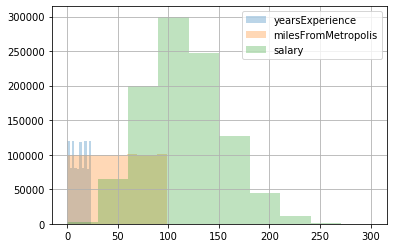

In [11]:
for col in numeric.columns.tolist():
    numeric[col].hist(alpha = 0.3)
    plt.legend([col for col in numeric.columns])

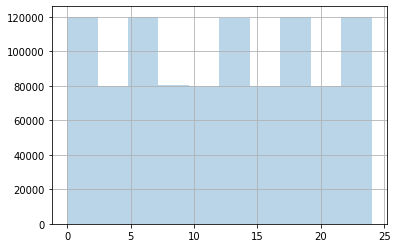

In [12]:
numeric['yearsExperience'].hist(alpha = 0.3)

**Summary**: Salary follows a relatively ***Normal Gaussian Distribution***.
- yearsExperience and milesFromMetropolis are **uniformly distributed**

## Understanding Categorical Features vs. Salary

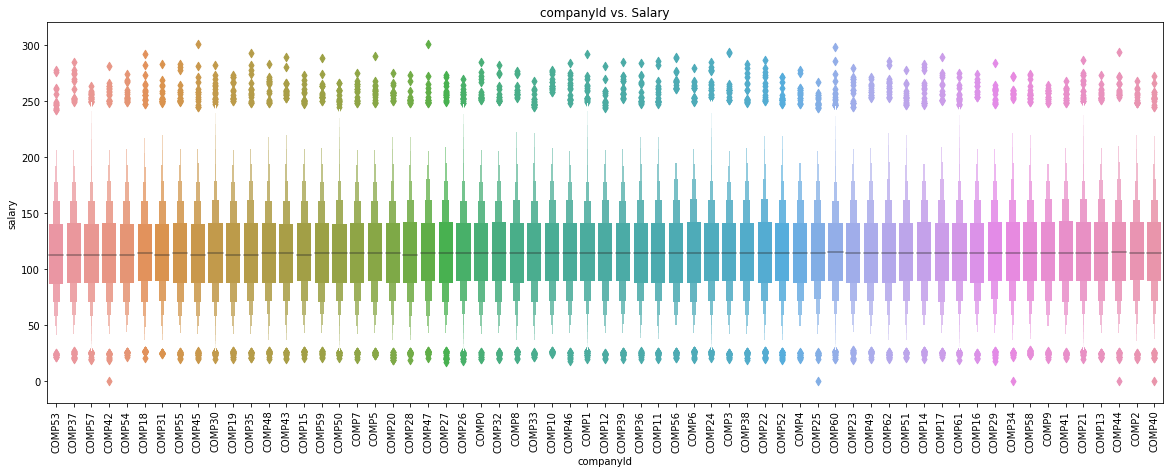

In [13]:
plot_viz('companyId')

**Summary**: Salary tends to be relatively ***constant*** across different companies.

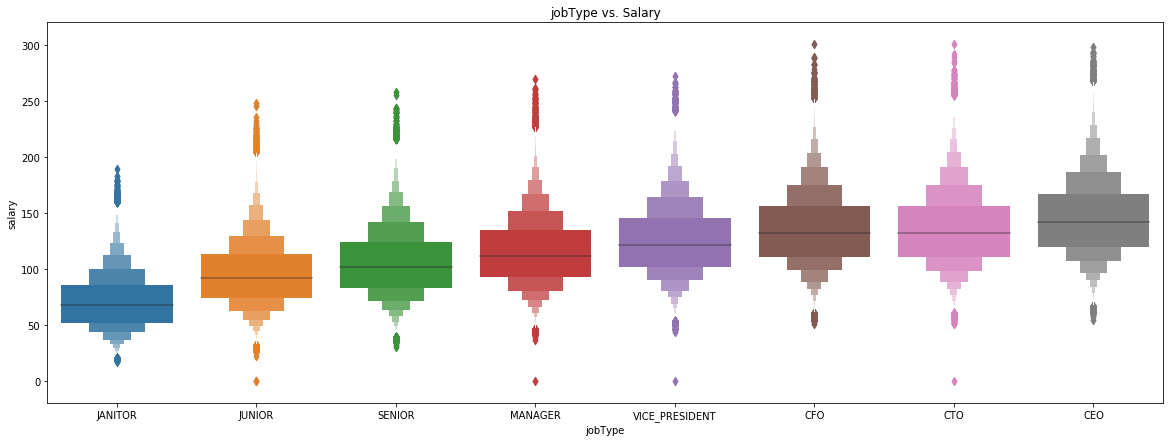

In [14]:
plot_viz('jobType')

**Summary**: Salary ***increases*** as one gets a better jobType.

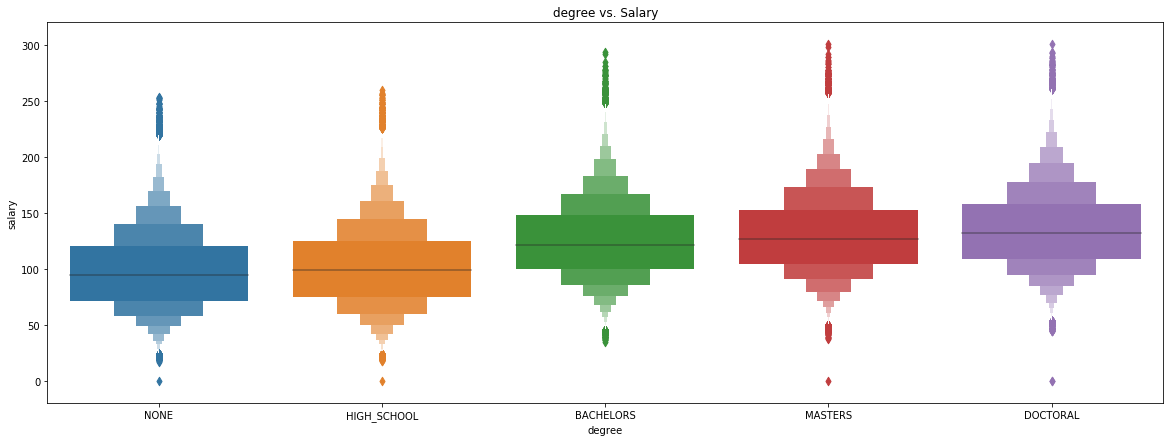

In [15]:
plot_viz('degree')

**Summary**: Salary ***increases*** the more advanced a degree one has.

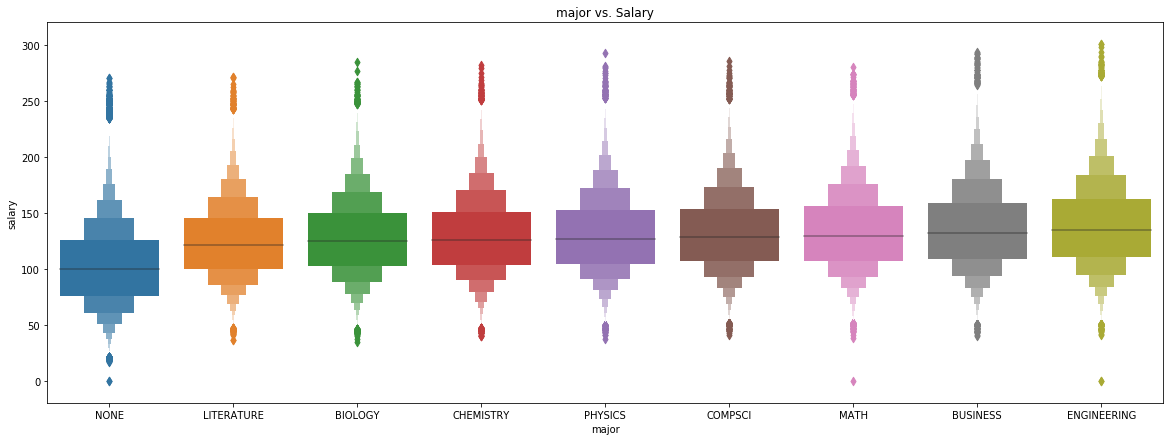

In [16]:
plot_viz('major')

**Summary**: Salary is ***higher on average*** for Math, Business, and Engineering majors.

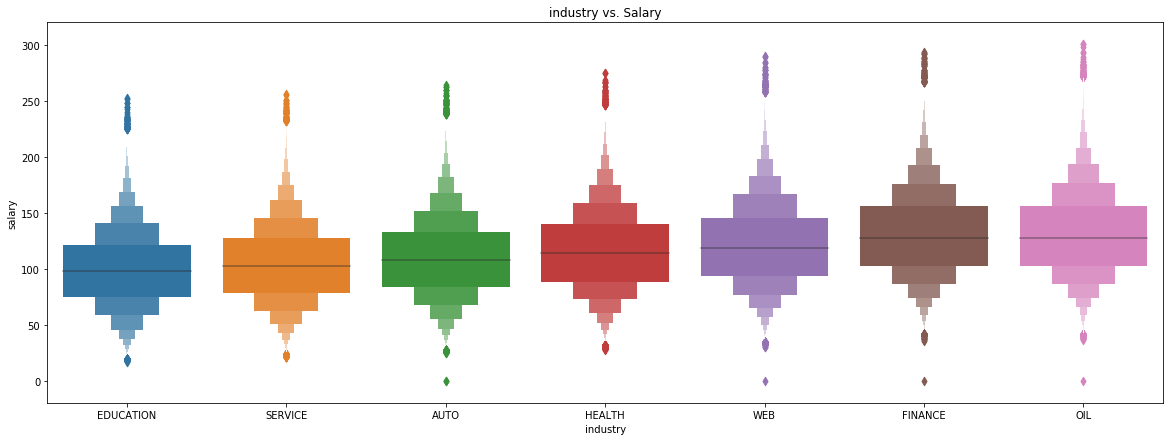

In [17]:
plot_viz('industry')

**Summary**: Salary is ***higher on average*** for employees in Web, Finance, and Oil industries.

In [18]:
cat = cat.drop('companyId', axis = 1) #Can't be introduced into a model in a meaningful way as it has similar AVG Salaries

#### One Hot Encode [cat] to feed into ML model

In [19]:
OH_cat = pd.get_dummies(cat, drop_first= True)

## Understanding Numerical Features vs. Salary

In [20]:
train_full.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.375013
milesFromMetropolis,0.000673,1.000000,-0.297666
salary,0.375013,-0.297666,1.000000


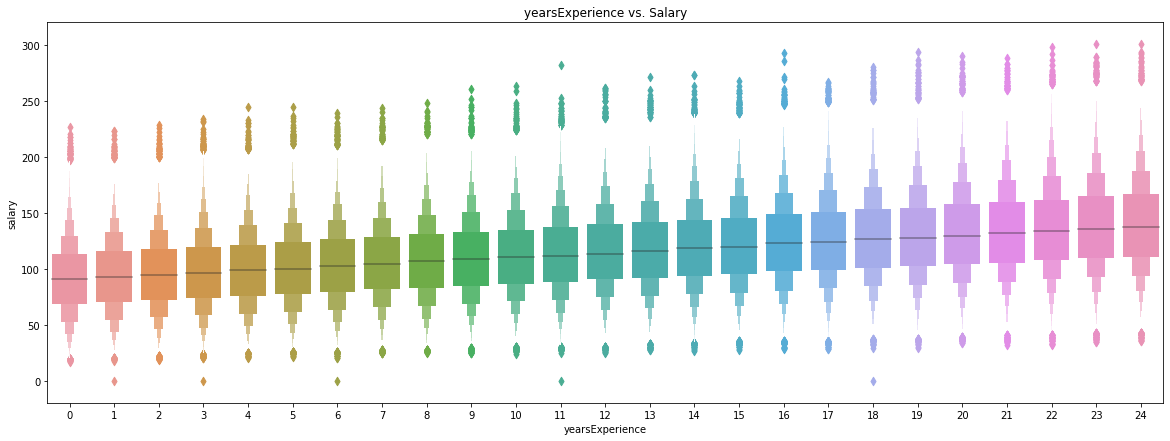

In [21]:
plot_viz('yearsExperience')

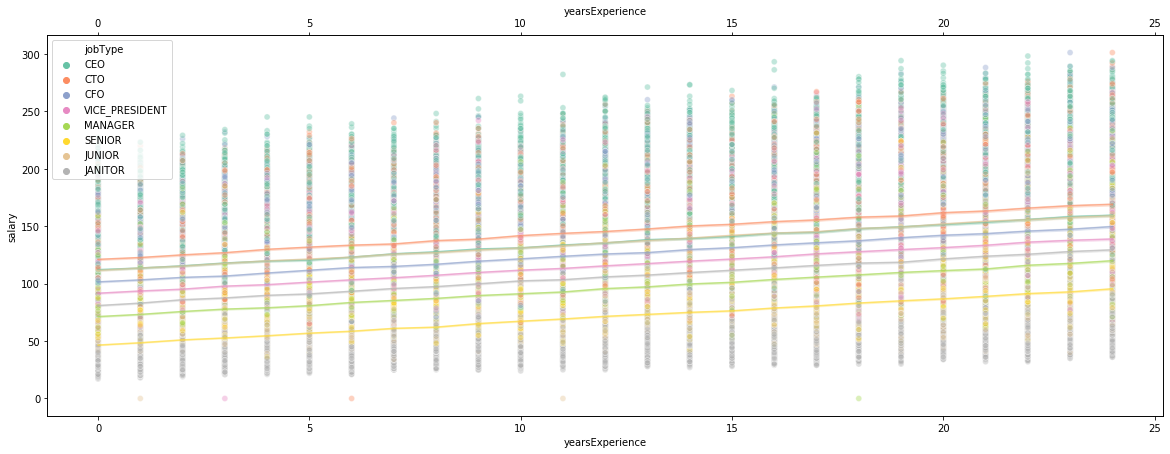

In [22]:
fig, ax0 = plt.subplots(figsize= (20,7))
ax0 = sns.scatterplot(x = 'yearsExperience', y = 'salary', data= train_full, hue = 'jobType',
                      palette= 'Set2', alpha = 0.4, hue_order= feature_order('jobType',ascending = False))
ax1 = ax0.twiny()
ax1 = sns.lineplot(x = 'yearsExperience', y = 'salary', data= train_full,
                hue = 'jobType', palette= 'Set2', alpha = 0.6, legend= False)

**Summary**: YearsExperience & jobType have a ***positive*** correlations with salary: Salary **increases** with more experience and a better title in the organization.

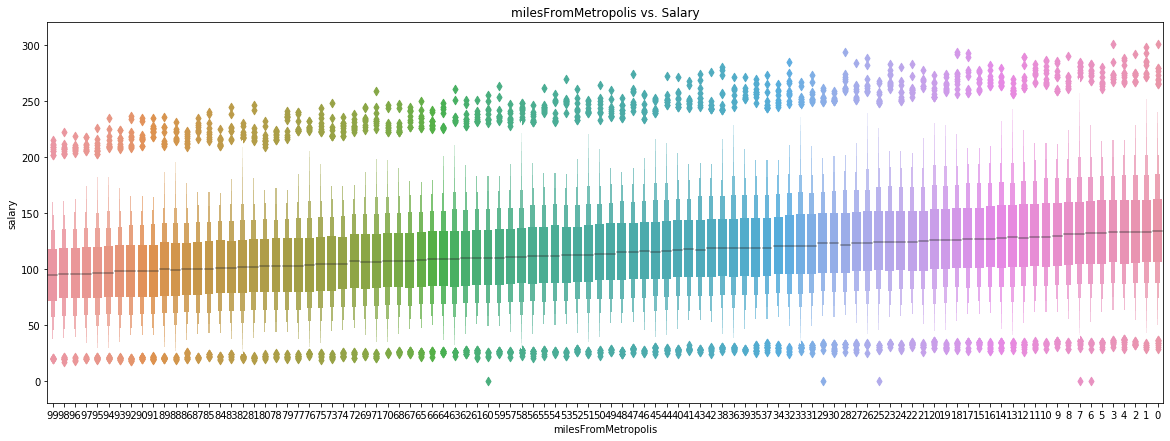

In [23]:
plot_viz('milesFromMetropolis')

**Summary**: milesFromMetropolis has a ***negative*** correlation with salary: Employees get paid less the more miles they travel to work. <t>This trend is also consistent with the *correlation table* above.

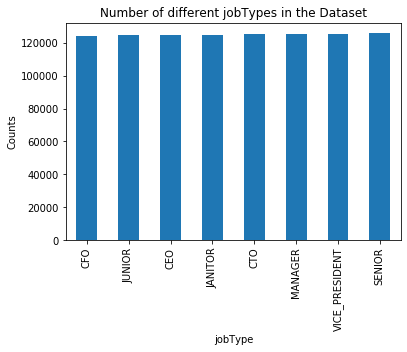

In [24]:
plt.title('Number of different jobTypes in the Dataset')
plt.ylabel('Counts')
train_full.groupby('jobType')['salary'].count().sort_values(ascending = True).plot(kind = 'bar')

**Summary**: The Distribution of jobTypes is relatively *equal*

### Create & Drop id col used to merge c and n

In [25]:
OH_cat['id'] = range(OH_cat.shape[0])
numeric['id'] = range(numeric.shape[0])

/Users/vanamsid/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
X_full = pd.merge(OH_cat,numeric, on = 'id')

## Find outliers in the Target variable: LOW and HIGH

In [27]:
upper_outliers = find_outliers(train_full, feature = 'salary', lower = False)
upper_outliers

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
685562,COMP47,CTO,MASTERS,ENGINEERING,OIL,24,0,301
400611,COMP45,CFO,DOCTORAL,ENGINEERING,OIL,23,3,301
572777,COMP60,CEO,MASTERS,ENGINEERING,OIL,22,1,298
911747,COMP3,CEO,BACHELORS,BUSINESS,FINANCE,24,28,294
293221,COMP44,CEO,DOCTORAL,ENGINEERING,OIL,19,18,294
905713,COMP35,CEO,DOCTORAL,BUSINESS,FINANCE,16,17,293
503962,COMP3,CEO,DOCTORAL,PHYSICS,OIL,24,1,293
884902,COMP1,CTO,MASTERS,BUSINESS,FINANCE,24,2,292
47203,COMP18,CEO,BACHELORS,BUSINESS,FINANCE,22,18,292
377196,COMP5,CEO,DOCTORAL,ENGINEERING,WEB,20,8,290


**Summary**: Nothing totally unusual about the upper-bound outliers. There are some high paying salaries for individuals with only 'Bachelors' degrees but often they are CEOs and so this inflated salary is justified.

With more time we would learn more information about these unique employees with lower education and a higher position in the company

In [28]:
#LOW
lower_outliers = find_outliers(train_full, 'salary', lower = True)
lower_outliers

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
495984,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
828156,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0
816129,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
30559,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
652076,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
141942,COMP27,JANITOR,NONE,NONE,EDUCATION,0,98,17
807108,COMP29,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,0,92,18
188931,COMP26,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,96,18
482429,COMP46,JANITOR,NONE,NONE,EDUCATION,0,92,18
692832,COMP20,JANITOR,NONE,NONE,EDUCATION,0,88,19


**Summary**: Suspicious to find salaries = 0, higher levels positions such as "Vice Presidents" and "CTOs" should earn some money. 
Similarly we assume there are no unpaid internships for Junior jobTypes. But in reality we would check with the data source or data collection team to inquire more about these outliers.
### To account for these outliers, we DROP these rows from both the train and test set 

In [29]:
outlier_indices = lower_outliers.reset_index().iloc[:5]['index']

In [30]:
X_full = X_full.drop(outlier_indices)
test_features = test_features.drop(outlier_indices)

In [31]:
X_full = X_full.drop('id', axis = 1)

## Combine [num] and [cat] data and then create Train and Target tables w/ train_test_split AFTER dropping outliers 

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
y_full = X_full['salary']
X_Full = X_full.drop('salary', axis = 1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_Full, y_full, shuffle = True,
            test_size = 0.2, random_state = 42)

Allocates 20% of the data for testing while using the remaining 80% for training the models

## Turn all Train and Test splits into pickle objects for the Model Selection Notebook

In [35]:
import pickle

In [36]:
with open('../salary prediction data/TRAIN_X.pkl', 'wb') as temp0:
    pickle.dump(X_train, temp0)
with open('../salary prediction data/TEST_X.pkl', 'wb') as temp1:
    pickle.dump(X_test, temp1)
with open('../salary prediction data/TRAIN_Y.pkl', 'wb') as temp2:
    pickle.dump(y_train, temp2)
with open('../salary prediction data/TEST_Y.pkl', 'wb') as temp3:
    pickle.dump(y_test, temp3)

Save the split data for training and testing the models in the subsequent notebook